In [1]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath("../"))  # importa dalla radice del progetto
from src import core
from src import pre_processing


In [10]:
data = core.import_data("/home/zampa/projects/ProMeteo/data/test_data.csv")
time_array = data.index
u = data["u"].to_numpy()

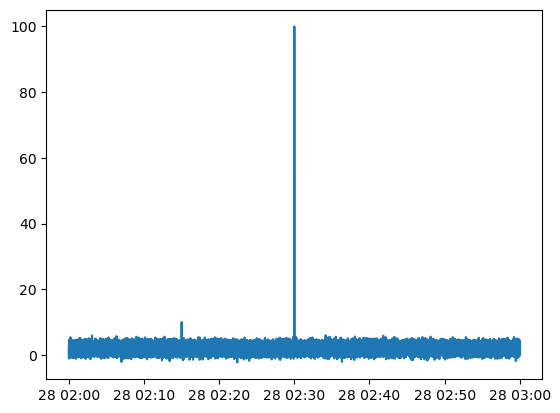

In [11]:
plt.plot(time_array, u)

In [14]:
u_cleaned, _ = pre_processing.remove_beyond_threshold(u, 30)

In [32]:
u_cleaned.shape

(72001,)

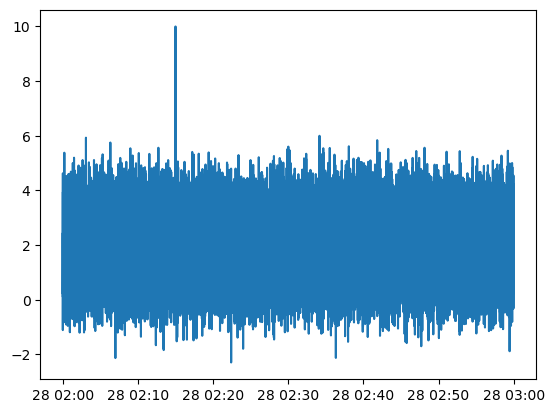

In [15]:
plt.plot(time_array, u_cleaned)

In [16]:
# valori oltre 30 effettivamente rimossi

In [18]:
# n_rows=15*60*20 # segnale a 20 Hz di durata 30 min
# array_example_1=np.random.normal(loc=2, scale=1, size=n_rows) # [m/s]
# array_example_2=np.random.normal(loc=4, scale=1, size=n_rows) # [m/s]
# array_example=np.concatenate([array_example_1, array_example_2])
# run_mean_ex, std_mean_ex = core.running_stats(array_example, 6001) # finestra di 5 min
# index=np.arange(0,len(array_example))
# plt.plot(index, array_example)
# plt.plot(index, run_mean_ex)


In [ ]:
# run_mean, std_mean = core.running_stats(u_cleaned, 6001)
u_despiked_VM97 = pre_processing.despiking_VM97(u_cleaned, 3.5, 6001, 3, 5, None)

Text(0.5, 1.0, 'Modified values: 32')

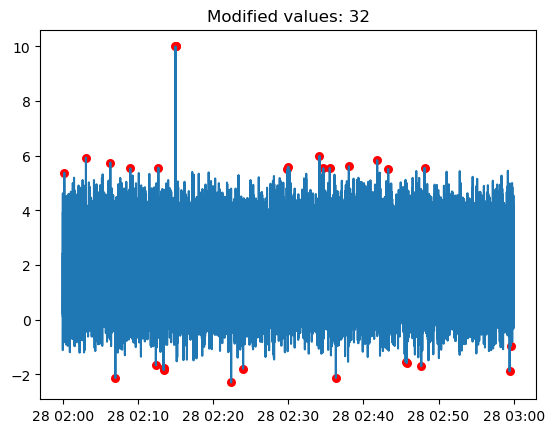

In [23]:
mask=u_cleaned != u_despiked_VM97
plt.plot(data.index, u_cleaned)
plt.scatter(time_array[mask], u_cleaned[mask], s=30, color='r')
plt.title(f"Modified values: {sum(mask)}")
# plt.xlim(pd.to_datetime("2012-09-28 02:10:00"),
#          pd.to_datetime("2012-09-28 02:20:00"))

In [26]:
u_despiked_robust, _ = pre_processing.despiking_robust(u_cleaned,
                                                    3.5,
                                                    6001)

Text(0.5, 1.0, 'Modified values: 49')

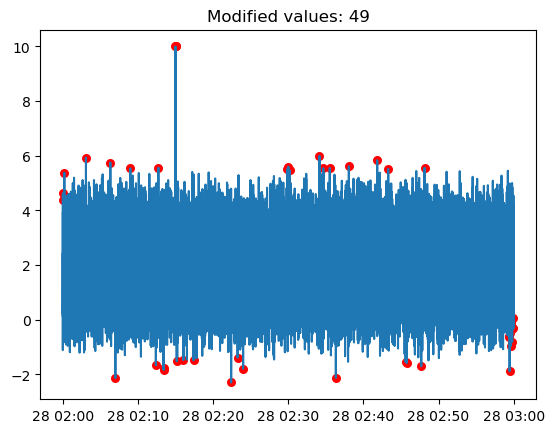

In [29]:
mask_robust = u_cleaned != u_despiked_robust
plt.plot(data.index, u_cleaned)
plt.scatter(time_array[mask_robust], u_cleaned[mask_robust], s=30, color='r')
plt.title(f"Modified values: {sum(mask_robust)}")